# Data Cleaning and Feature Engineering

This notebook contains the basic cleaning of my scraped dataset as well as the engineering of additional features, namely based on the short info section of each walk page. 

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from math import floor

df_raw=df=pd.read_csv('Walkhighlands_raw.csv',index_col=0)

In [2]:
print(df_raw.head())
print(df_raw.info())

                                        name  \
0  Ceannabeinne Township Trail, near Durness   
1       Forsinard Flows and Tower, Forsinard   
2                         Borgie Forest walk   
3                              Melvich Beach   
4                  Portskerra pier and jetty   

                                                info      region  dist  \
0  This short walk round the site of an abandoned...  sutherland  1.00   
1  This short but truly unique walk gives a fasci...  sutherland  1.50   
2  This short forestry walk briefly follows the R...  sutherland  1.75   
3  This short walk leads out to Melvich Beach - o...  sutherland  1.75   
4  This short loop links the pier and the jetty a...  sutherland  2.00   

   ascent  corbett  munro  grade  bog  rating  
0    65.0        0      0      1    1    3.80  
1     6.0        0      0      1    1    3.71  
2    34.0        0      0      1    1    1.43  
3    16.0        0      0      1    1    4.20  
4    56.0        0      0 

Looking at this we see a mixture of data types with some null vlaues in the 'info' and 'rating' columns. To tidy this up I have decided to convert all of my numeric data to floats, which will make scaling this data for use in my modelling simpler. To address the null values I have decide to drop all rows with null data, I could have filled the missing rating data with the mean but felt this was not appropriate when an aim of my project has ratings as a target variable. Similarly, I decided to drop walks with missing info sections as using features extracted from this is a central part of my project.

In [3]:
df_cleaned=df_raw.copy().dropna()
df_cleaned[['corbett','munro','grade','bog']]=df_cleaned[['corbett','munro','grade','bog']].astype('float')
df_cleaned.reset_index(inplace=True,drop=True)

In [4]:
df_cleaned.to_csv('Walkhighlands_cleaned.csv')

Now that we have saved a basic version for some quick visualisation, let's move onto engineering features for more detailed visualsiations and to use in some models. For a start, I will one hot encode the region feature.

In [5]:
encoder=OneHotEncoder()
df_region=pd.DataFrame(encoder.fit_transform(df['region'].to_numpy().reshape(-1, 1)).toarray())
df_region.columns=encoder.get_feature_names_out(['region'])

In [6]:
df_eng=df_cleaned.drop(['region'],axis=1).join(df_region)
#print(df_eng)

# New features from natural language processing

The 'info' column in the DataFrame contains a short description of each walk, which I will experiment with using to create new features such as the presence of keywords that may correlate with the rating for the given walk. 

In [7]:
df_eng['info_split']=df_eng['info'].apply(lambda z: z.split())

In [8]:
words=set(df_eng['info_split'].sum())
new_words=set([])
for word in words:
    new_word=word.strip(',!?.();:').lower()
    new_words.add(new_word)
#print(new_words)
new_words=list(new_words)
filtered_words=[word for word in new_words if word not in stopwords.words('english')]
print(len(filtered_words))

5864


Now that we have a list of words that appear in the info feature, we can look at which words might make useful features. Particularly, it seems useful to set a minimum fequency so that ensure each feature contains at least a minimum amount of useful information. An additonal useful side effect of this is, we can significatly reduce the number of features I need to create.

One very important note: making a decision like this before performing the train-test split would constitute some possible information leak, so I will need to split my data before this step.

In [9]:
#takes in list of text and formats it 
def cleaned_text(text):
    new_text=[]
    for word in text:
        new_text.append(word.strip(',!?.();:').lower())
    return new_text

In [10]:
df_eng['info_split']=df_eng['info_split'].apply(lambda z: cleaned_text(z))

In [11]:
for word in filtered_words:
    df_word=df_eng['info_split'].apply(lambda z: int(word in z))
    df_word.rename(word, inplace=True)
    df_eng=df_eng.join(df_word,lsuffix='_original')

    
#running this multple times was a bad idea

In [12]:
print(df_eng)

                                        name_original  \
0           Ceannabeinne Township Trail, near Durness   
1                Forsinard Flows and Tower, Forsinard   
2                                  Borgie Forest walk   
3                                       Melvich Beach   
4                           Portskerra pier and jetty   
...                                               ...   
1538  Da Kame, Da Sneug & Da Noup: the complete Foula   
1539         Fair Isle North Lighthouse & Observatory   
1540                             Ward Hill, Fair Isle   
1541         Malcolm's Head and Sheep Rock, Fair Isle   
1542                  The Complete Fair Isle explorer   

                                                   info   dist  \
0     This short walk round the site of an abandoned...   1.00   
1     This short but truly unique walk gives a fasci...   1.50   
2     This short forestry walk briefly follows the R...   1.75   
3     This short walk leads out to Melvich Beach - 

# Test Train split

In [13]:
df_train, df_test=train_test_split(df_eng, random_state=0)

In [14]:
print(np.shape(df_train),np.shape(df_test))

(1157, 5895) (386, 5895)


In [15]:
word_freq=df_train[filtered_words].sum().sort_values(ascending=False)
print(word_freq)

walk        622
views       447
route       270
short       251
loch        215
           ... 
creator       0
carse         0
gairich       0
craobh        0
fhithich      0
Length: 5864, dtype: int64


In [16]:
#print(word_freq[word_freq>50].to_string())

Now use this frequency to remove words with fewer than 50 instances in the training data

In [17]:
rare_words=word_freq[word_freq<50]

In [18]:
df_train.drop(columns=rare_words.index,axis=1, inplace=True)
df_test.drop(columns=rare_words.index,axis=1, inplace=True)

df_train.drop(columns=['name_original','info','info_split'],axis=1, inplace=True)
df_test.drop(columns=['name_original','info','info_split'],axis=1, inplace=True)

Now all is left to do is save these DataFrames 

In [19]:
df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

In [20]:
#print(df_train)

# Slim down the features 

take a more selective approach to the features used 

In [21]:
np.shape(df_train)[0]

1157

In [22]:
rating_dict={}
count_dict={}
for feature in df_train.columns:
    new_df=df_train[df_train[feature]!=0]
    rating_dict[feature]=new_df['rating'].mean()
    count_dict[feature]=np.shape(new_df['rating'])[0]
feature_rating=pd.Series(rating_dict).dropna()
feature_count=pd.Series(count_dict).dropna()


In [23]:
print(feature_rating.sort_values().to_string())
#print(feature_count.sort_values().to_string())

forestry                 3.115441
pleasant                 3.141406
track                    3.251552
region_perthshire        3.258333
visit                    3.263297
easy                     3.281781
waymarked                3.285957
area                     3.298929
forest                   3.301471
good                     3.319396
woodland                 3.322871
river                    3.325806
via                      3.330556
region_cairngorms        3.334018
old                      3.345068
region_moray             3.347027
glen                     3.356667
moorland                 3.362069
region_kintail           3.370667
region_aberdeenshire     3.370984
circular                 3.375370
section                  3.376190
region_mull              3.378293
approach                 3.383158
follows                  3.392800
region_lochness          3.395098
climb                    3.396780
way                      3.406286
village                  3.409531
short         

In [24]:
df_rating=pd.DataFrame.from_dict(rating_dict, orient='index',columns=['rating'])
df_rating_count=df_rating.join(feature_count.rename('count'))

In [25]:
df_rating_count.to_csv('df_rating_count')

let's hypothesis test the features? The problem may well that the data is not normally distributed, althought the plot did look quite good.

the models I'm using are not very sensitve to feature selection so I'm not sure it is that valuable to try this 

# Create a classification version of the data 

In [26]:
y_train_class=df_train['rating'].apply(lambda z: floor(z))


y_test_class=df_test['rating'].apply(lambda z: floor(z))


In [27]:
print(y_train_class.value_counts()) #might be better to split this another way? 

3    685
4    268
2    189
5     13
1      2
Name: rating, dtype: int64


In [28]:
#df_train[df_train['rating']==5]

<BarContainer object of 5 artists>

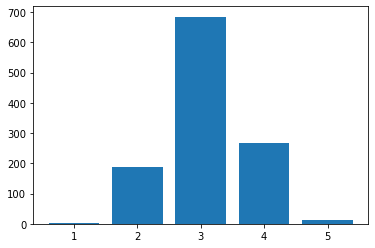

In [29]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(y_train_class.value_counts().index,y_train_class.value_counts().values)

I pic catagories <3 star, 3-4 star and >4 star for the data. without doign this is caues problems in the fitting the model 

In [34]:
def group_rating(z):
    if z<3:
        return 0
    if 3<=z<4:
        return 1
    else:
        return 2


y_train_class=df_train['rating'].apply(lambda z:  group_rating(z))


y_test_class=df_test['rating'].apply(lambda z: group_rating(z))

print(y_train_class.value_counts())

1    685
2    281
0    191
Name: rating, dtype: int64


In [35]:
y_train_class.to_csv('y_train_class.csv')
y_test_class.to_csv('y_test_class.csv')

# Binary rating

In [39]:
def binary_rating(z):
    if z<4:
        return 0
    else:
        return 1


y_train_binary=df_train['rating'].apply(lambda z:  binary_rating(z))


y_test_binary=df_test['rating'].apply(lambda z: binary_rating(z))

print(y_train_binary.value_counts())

0    876
1    281
Name: rating, dtype: int64


In [37]:
y_train_binary.to_csv('y_train_binary.csv')
y_test_binary.to_csv('y_test_binary.csv')

In [40]:
y_train_binary.unique()

array([1, 0], dtype=int64)

In [2]:
281/(281+876) # not too imbalanced 

0.2428694900605013